In [1]:
import pvdeg
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from typing import Union

In [2]:
import pvdeg.stressor


path=r'C:\Users\tford\Downloads\Simple Setpoints.csv'

df = pvdeg.stressor.create_set_point_df(
    t_0=0,
    rh_0=0,
    irrad_0=0,
    v_0=0,
    fp=path
    )

df

,step_length,temperature,temperature_ramp,relative_humidity,relative_humidity_ramp,irradiance,irradiance_ramp,voltage,voltage_ramp,time_resolution
0,0,0,0,0,0,0,0,0,0,1
1,15,40,0,85,0,0,0,0,0,1
2,30,0,0,0,0,0,0,0,0,1
3,40,60,0,60,0,0,0,0,0,1
4,60,60,0,60,0,0,0,0,0,1


In [3]:
new = pvdeg.stressor.start_times(df)
new

,step_length,temperature,temperature_ramp,relative_humidity,relative_humidity_ramp,irradiance,irradiance_ramp,voltage,voltage_ramp,time_resolution,start_time
0,0,0,0,0,0,0,0,0,0,1,0.0
1,15,40,0,85,0,0,0,0,0,1,0.0
2,30,0,0,0,0,0,0,0,0,1,15.0
3,40,60,0,60,0,0,0,0,0,1,45.0
4,60,60,0,60,0,0,0,0,0,1,85.0


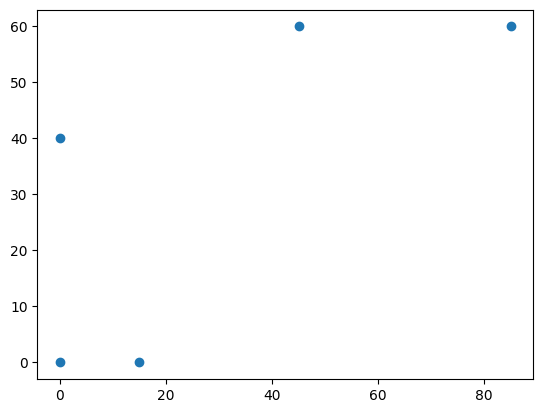

In [4]:
plt.scatter(new['start_time'], new['temperature'])

In [5]:
values = pvdeg.stressor.fill_linear_region(
    step_time=10,step_time_resolution=1,
    set_0=40,
    set_f=10, 
    rate=0
)

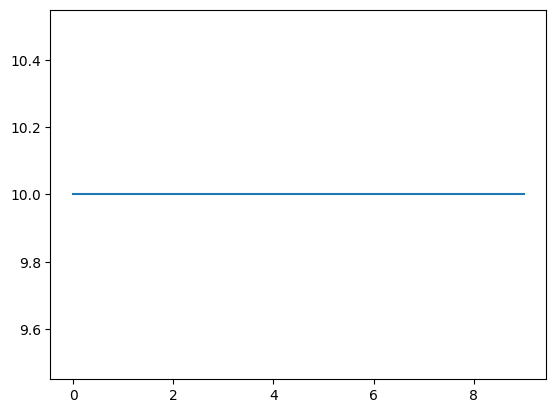

In [6]:
plt.plot(values)

## Redo this so it is a series with the correct time indexes. 

Not sure how to do this with datetime without the dates. Or we just start 1/1/1970 (UNIX epoch start)

In [7]:
pvdeg.stressor.chamber_set_points_timeseries(df)

array([40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40.,
       40., 40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., 60., 60., 60., 60., 60., 60., 60.,
       60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60.,
       60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60.,
       60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60.,
       60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60.,
       60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60.,
       60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60.,
       60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60.,
       60., 60.])